In [1]:
testing_loss = []

In [2]:
import os
import torch
import pickle

from MeLU import MeLU
from options import config
from model_training import training
from data_generation import generate
from evidence_candidate import selection
from tqdm import tqdm


if __name__ == "__main__":
    master_path= "./ml"
    if not os.path.exists("{}/".format(master_path)):
        os.mkdir("{}/".format(master_path))
        # preparing dataset. It needs about 22GB of your hard disk space.
        generate(master_path)

    # training model.
    melu = MeLU(config)
    state = "item_cold_state"
    model_filename = "{}/models_{}.pkl".format(master_path,state)
    if not os.path.exists(model_filename):
        # Load training dataset.
        training_set_size = int(len(os.listdir("{}/{}".format(master_path,state))) / 4)
        supp_xs_s = []
        supp_ys_s = []
        query_xs_s = []
        query_ys_s = []
        for idx in tqdm(range(training_set_size)):
            supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format(master_path,state, idx), "rb")))
            supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format(master_path, state, idx), "rb")))
            query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format(master_path, state, idx), "rb")))
            query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format(master_path, state, idx), "rb")))
        total_dataset = list(zip(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s))
        del(supp_xs_s, supp_ys_s, query_xs_s, query_ys_s)
        history = training(melu, total_dataset, batch_size=config['batch_size'], num_epoch=config['num_epoch'], model_save=True, model_filename=model_filename)
    else:
        trained_state_dict = torch.load(model_filename)
        melu.load_state_dict(trained_state_dict)



C:\Users\rnautiyal2\Anaconda3\envs\charanfyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 40/40 [21:31<00:00, 32.30s/it]


[13.619757336378097, 7.035808692872524, 1.5823938943445683, 1.2690561439841985, 1.2088384602218867, 1.1725241720676423, 1.1438503742218018, 1.1234065648168325, 1.1065169803798198, 1.095781632885337, 1.0877541534602642, 1.0800133425742389, 1.078302376717329, 1.073998537659645, 1.0721808668226003, 1.0698647685348988, 1.068270417675376, 1.0670130252838135, 1.0642500281333924, 1.0645105596631765, 1.0638954777270555, 1.063303067907691, 1.0613784175366163, 1.0611183527857064, 1.0603121336549521, 1.0613146789371968, 1.0603933963924645, 1.0593689203262329, 1.0586059406399726, 1.0575107928365468, 1.057993995025754, 1.0578010734170675, 1.058361667022109, 1.0578515619039535, 1.0564696695655584, 1.0587079521268605, 1.0578836247324943, 1.0570324212312698, 1.0560165286064147, 1.056995154172182]


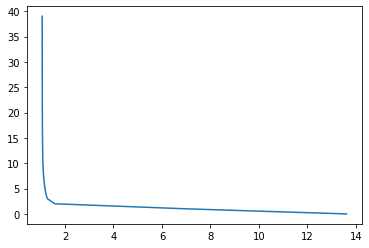

In [3]:
import matplotlib.pyplot as plt
y = list(range(len(history)))
print(history)
plt.plot(history,y)

In [4]:
# model_filename = "{}/models_{}.pkl".format(master_path,state)
# if not os.path.exists(model_filename):
# Load training dataset.
testing_set_size = int(len(os.listdir("{}/{}".format('testing',state))) / 4)
supp_xs_s = []
supp_ys_s = []
query_xs_s = []
query_ys_s = []
for idx in tqdm(range(testing_set_size)):
    supp_xs_s.append(pickle.load(open("{}/{}/supp_x_{}.pkl".format('testing',state, idx), "rb")))
    supp_ys_s.append(pickle.load(open("{}/{}/supp_y_{}.pkl".format('testing', state, idx), "rb")))
    query_xs_s.append(pickle.load(open("{}/{}/query_x_{}.pkl".format('testing', state, idx), "rb")))
    query_ys_s.append(pickle.load(open("{}/{}/query_y_{}.pkl".format('testing', state, idx), "rb")))

100%|██████████| 295/295 [00:04<00:00, 68.29it/s]


In [5]:
from torch.nn import functional as F
trained_state_dict = torch.load(model_filename)
melu.load_state_dict(trained_state_dict)

final_loss = []
for i in range(len(supp_xs_s)):
    prediction = melu.model(supp_xs_s[i].cuda())
    temp_loss = F.mse_loss(prediction, supp_ys_s[i].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

for j in range(len(query_xs_s)):
    prediction = melu.model(query_xs_s[j].cuda())
    temp_loss = F.mse_loss(prediction, query_ys_s[j].cuda().view(-1, 1))
    final_loss.append(temp_loss.item())

[1.0752187800609458]


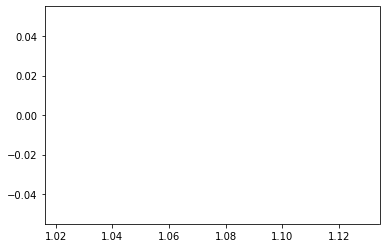

In [6]:
import numpy as np
testing_loss.append(np.mean(final_loss))
y = list(range(len(testing_loss)))
print(testing_loss)
plt.plot(testing_loss,y)